<a href="https://colab.research.google.com/github/wanchenlang-max/econ-lab/blob/main/econ_5200_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Spotify', 'Price_2016': 2.50, 'Price_2024': 4.50},
]

In [ ]:
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Spotify: 80.00% Inflation


In [4]:
!pip install fredapi
from fredapi import Fred

fred = Fred(api_key='81c60c295cc1091779d33f0d9cf1e342 ')

official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
Chipotle = fred.get_series('CUSR0000SEFV')
Spotify = fred.get_series('CUSR0000SERA02')

In [5]:
import pandas as pd

df_raw = pd.DataFrame({
    "Official CPI": official_cpi,
    "Tuition": tuition,
    "Rent": rent,
    "Spotify": Spotify,
    "Chipotle": Chipotle
}).sort_index()

start = pd.Timestamp("2016-01-01")

base_date = df_raw.index[df_raw.index.get_indexer([start], method="ffill")[0]]


df_index = df_raw.div(df_raw.loc[base_date]).mul(100)

print("Base date used:", base_date.date())
df_index.loc[base_date]

Base date used: 2016-01-01


,2016-01-01
Official CPI,100.0
Tuition,100.0
Rent,100.0
Spotify,100.0
Chipotle,100.0


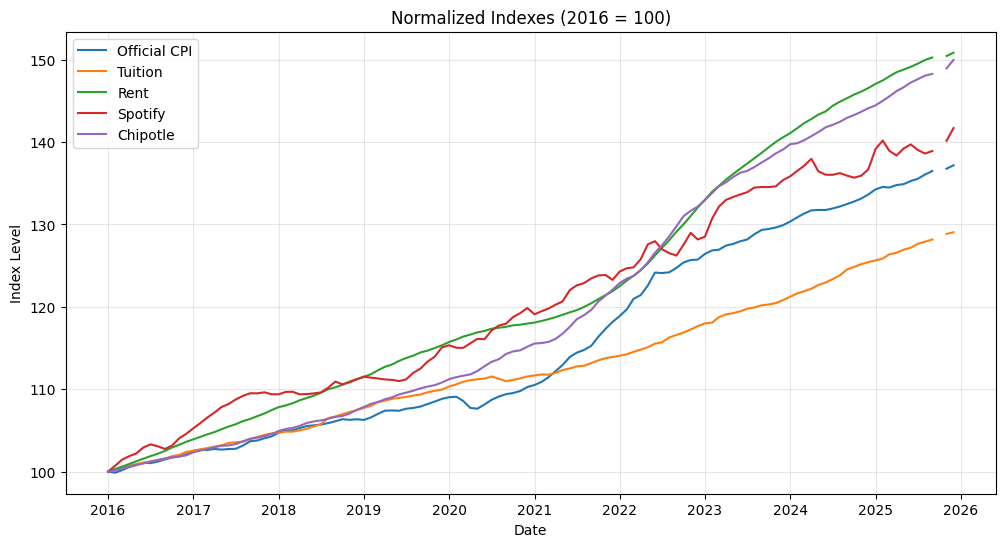

In [6]:
import matplotlib.pyplot as plt

df_plot = df_index.loc["2016-01-01":].copy()

plt.figure(figsize=(12,6))
for col in df_plot.columns:
    plt.plot(df_plot.index, df_plot[col], label=col)

plt.title("Normalized Indexes (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


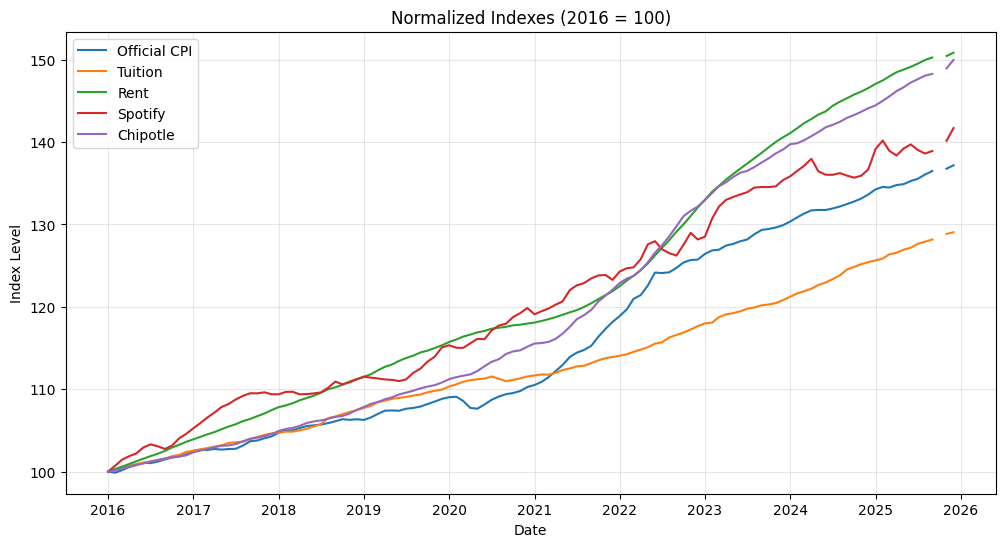

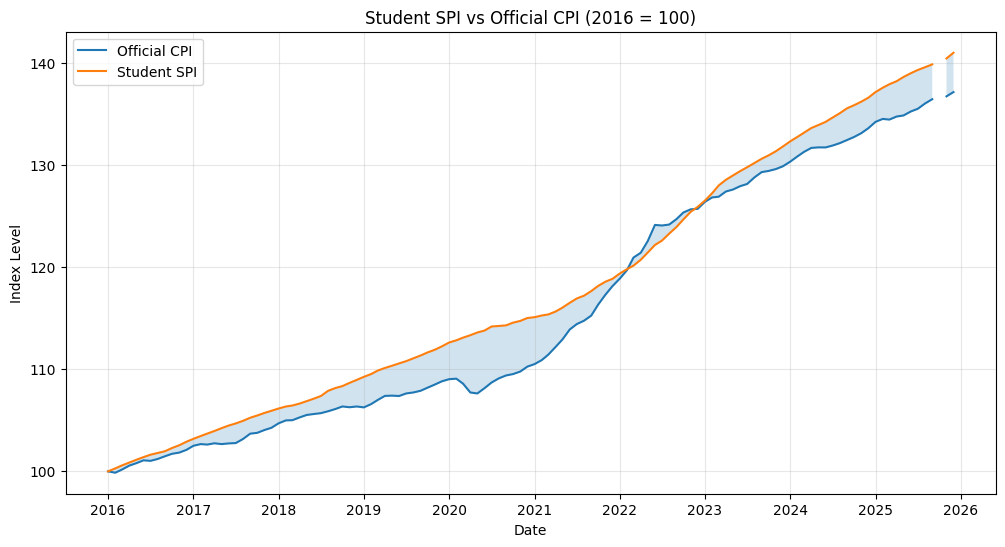

In [9]:
import matplotlib.pyplot as plt

df_plot = df_index.loc["2016-01-01":].copy()

plt.figure(figsize=(12,6))
for col in df_plot.columns:
    plt.plot(df_plot.index, df_plot[col], label=col)
weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Chipotle": 0.20,
    "Spotify": 0.10
}

df_plot["Student_SPI"] = (
    df_plot["Tuition"]   * weights["Tuition"] +
    df_plot["Rent"]      * weights["Rent"] +
    df_plot["Chipotle"] * weights["Chipotle"] +
    df_plot["Spotify"] * weights["Spotify"]
)

plt.title("Normalized Indexes (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.figure(figsize=(12,6))
plt.plot(df_plot.index, df_plot["Official CPI"], label="Official CPI")
plt.plot(df_plot.index, df_plot["Student_SPI"], label="Student SPI")


plt.fill_between(
    df_plot.index,
    df_plot["Official CPI"],
    df_plot["Student_SPI"],
    alpha=0.2
)

plt.title("Student SPI vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

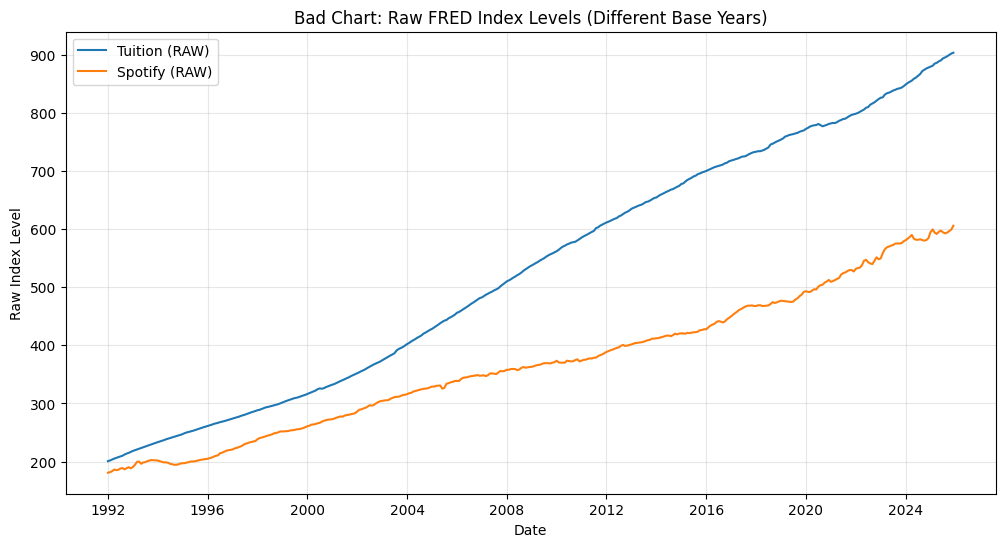

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df_bad = pd.DataFrame({
    "Tuition (RAW)": tuition,
    "Spotify (RAW)": Spotify
}).dropna()

plt.figure(figsize=(12,6))
plt.plot(df_bad.index, df_bad["Tuition (RAW)"], label="Tuition (RAW)")
plt.plot(df_bad.index, df_bad["Spotify (RAW)"], label="Spotify (RAW)")

plt.title("Bad Chart: Raw FRED Index Levels (Different Base Years)")
plt.xlabel("Date")
plt.ylabel("Raw Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The "Tuition" and "Spotify" CPI series from FRED are each calculated using different base years. Because of this, their raw index values are on completely different scales. If graphed together as originally reported, tuition costs appear disproportionately high while streaming services seem extremely low—creating a visual distortion that misrepresents their relative changes over time.
To make a fair and meaningful comparison, we adjust both series to a common starting point by setting 2016 as the reference year (2016 = 100). This rescaling allows us to observe how each category has actually moved relative to the same baseline.


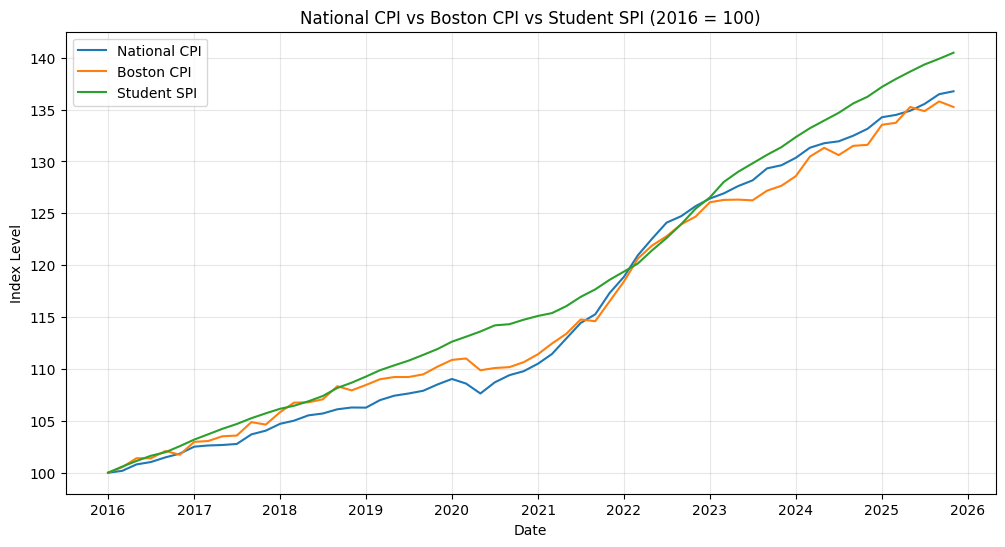

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

boston_cpi_raw = fred.get_series("CUURA103SA0")

df_compare = pd.DataFrame({
    "National CPI": df_index["Official CPI"],
    "Boston CPI (RAW)": boston_cpi_raw
}).sort_index()

base_date = pd.to_datetime("2016-01-01")
df_compare = df_compare.dropna(subset=["Boston CPI (RAW)"])

if base_date not in df_compare.index:
    base_date = df_compare.loc[:base_date].index[-1]

df_compare["Boston CPI"] = (df_compare["Boston CPI (RAW)"] / df_compare.loc[base_date, "Boston CPI (RAW)"]) * 100

df_compare["Student SPI"] = df_plot["Student_SPI"] # Corrected from df_index["Student_SPI"]
df_compare_plot = df_compare.loc["2016-01-01":].copy()

plt.figure(figsize=(12,6))
plt.plot(df_compare_plot.index, df_compare_plot["National CPI"], label="National CPI")
plt.plot(df_compare_plot.index, df_compare_plot["Boston CPI"], label="Boston CPI")
plt.plot(df_compare_plot.index, df_compare_plot["Student SPI"], label="Student SPI")

plt.title("National CPI vs Boston CPI vs Student SPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()